<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/ISOTIPO-Color.jpg" title="Title text" width="20%" />

<hr style="height:2px;border:none"/>
<H1 align='center'> Clasificación de Sentimiento de Reviews de peliculas </H1>

<H3> INF-396 Introducción a la Ciencia de Datos </H3>
<H3> Autor: Francisco Andrades </H3>

Lenguaje: Python

Temas:

    - Sentiment Analysis
    - Feed Forward, RNN, LSTM
    - Embedding GLOVE
<hr style="height:2px;border:none"/>

In [1]:
## Puede encontrar información sobre keras en https://keras.io/getting_started/intro_to_keras_for_engineers/
## Puede encontrar información sobre sklearn en https://scikit-learn.org/stable/

import os
import numpy as np
import pickle

Primero, carguemos en memoria el conjunto de datos y veamos algunos de sus datos

In [2]:
classes = ['negative', 'positive']
X_train, y_train, X_test, y_test = pickle.load(open('movies_review_train_test.dat', 'rb'))

## Modelos de redes neuronales

In [3]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Embedding, LSTM, SimpleRNN, Add, Lambda, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [4]:
# Definición de parámetros
batch_size = 32
epochs = 2
num_classes = 2
max_words = 70
embedding_size = 30

### Preprocesamiento
A continuación preprocesaremos los datos, realizando tokenización.

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenizing text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train + X_test)
word_index = tokenizer.word_index
num_words = len(tokenizer.word_index) + 1

In [6]:
# Transformando texto a secuencias de indices
X_tr = tokenizer.texts_to_sequences(X_train)
X_te = tokenizer.texts_to_sequences(X_test)

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
# Se agregan 0 a textos que tienen menos de max_words palabras y se cortan los que tienen mas
X_tr_pad = pad_sequences(X_tr, maxlen=max_words)
X_te_pad = pad_sequences(X_te, maxlen=max_words)
# Se convierten label a version categorica
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Entrenando los modelos 

## Red neuronal feedforward

Primero entrenaremos una red neuronal feedforward directamente en el texto tokenizado, utilizando un embedding simple.

In [8]:
document_input = Input(shape=(max_words, ), dtype='int32')


x = Embedding(num_words, embedding_size, input_length=max_words)(document_input)
f = Lambda(lambda x: K.sum(x,axis=1))(x)
y = Dense(20, activation='relu')(f)
output = Dense(num_classes, activation='softmax')(y)


# Construyendo el modelo
model = Model(inputs=[document_input], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='adam',
             metrics=['accuracy'])

# Entrenando el modelo
history = model.fit(X_tr_pad, y_train,
                  batch_size=batch_size,
                  epochs=2,
                  verbose=1,
                  validation_split=0.2)

Train on 12000 samples, validate on 3000 samples
Epoch 1/2
12000/12000 [==============================] - 28s 2ms/sample - loss: 0.4737 - accuracy: 0.7617 - val_loss: 0.3845 - val_accuracy: 0.8183
Epoch 2/2
12000/12000 [==============================] - 25s 2ms/sample - loss: 0.1951 - accuracy: 0.9244 - val_loss: 0.4202 - val_accuracy: 0.8223


In [9]:
loss, acc = model.evaluate(X_te_pad, y_test)
print('Accuracy en datos de test: {0}'.format(acc))

3000/3000 [==============================] - 0s 124us/sample - loss: 0.4422 - accuracy: 0.8187
Accuracy en datos de test: 0.8186666369438171


# Red Neuronal Recurrente Simple con Embedding

In [10]:
document_input = Input(shape=(max_words, ), dtype='int32')
# Embedding Layer
embedding = Embedding(input_dim=num_words, output_dim=embedding_size, 
                      input_length=max_words, 
                      trainable=True)(document_input)

rnn = SimpleRNN(10,return_sequences=False)(embedding)



# Aplicando una capa densa luego de la RNN
output = Dense(num_classes, activation='softmax')(rnn)

# Construyendo el modelo
model = Model(inputs=[document_input], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='adam',
             metrics=['accuracy'])

# Entrenando el modelo
history = model.fit(X_tr_pad, y_train,
                  batch_size=batch_size,
                  epochs=2,
                  verbose=1,
                  validation_split=0.2)

Train on 12000 samples, validate on 3000 samples
Epoch 1/2
12000/12000 [==============================] - 38s 3ms/sample - loss: 0.6483 - accuracy: 0.6045 - val_loss: 0.5158 - val_accuracy: 0.7547
Epoch 2/2
12000/12000 [==============================] - 38s 3ms/sample - loss: 0.3240 - accuracy: 0.8684 - val_loss: 0.4545 - val_accuracy: 0.7887


In [11]:
loss, acc = model.evaluate(X_te_pad, y_test)
print('Accuracy en datos de test: {0}'.format(acc))

3000/3000 [==============================] - 1s 425us/sample - loss: 0.4975 - accuracy: 0.7603
Accuracy en datos de test: 0.7603333592414856


## Dropout para evitar el sobre ajuste

In [12]:
document_input = Input(shape=(max_words, ), dtype='int32')
# Embedding Layer
embedding = Embedding(input_dim=num_words, output_dim=embedding_size, 
                      input_length=max_words, 
                      trainable=True)(document_input)


rnn = SimpleRNN(10,dropout=0.4,return_sequences=False)(embedding)

'''  -----------  '''

# Aplicando una capa densa luego de la RNN
output = Dense(num_classes, activation='softmax')(rnn)

# Construyendo el modelo
model = Model(inputs=[document_input], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='adam',
             metrics=['accuracy'])

# Entrenando el modelo
history = model.fit(X_tr_pad, y_train,
                  batch_size=batch_size,
                  epochs=2,
                  verbose=1,
                  validation_split=0.2)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 12000 samples, validate on 3000 samples
Epoch 1/2
12000/12000 [==============================] - 39s 3ms/sample - loss: 0.6243 - accuracy: 0.6433 - val_loss: 0.4818 - val_accuracy: 0.7687
Epoch 2/2
12000/12000 [==============================] - 38s 3ms/sample - loss: 0.3619 - accuracy: 0.8530 - val_loss: 0.4005 - val_accuracy: 0.8170


## Explique aquí Dropout

Dropout significa "ignorar" algunas neuronas al azar (cantidad de acuerdo al dropout rate) para los pasos forward propagation o backward propagation. Esto ayuda a prevenir el overfitting, ya que la red se ve forzada a poder generalizar con un subconjunto de neuronas y a no desarrollar codependencias entre neuronas.

In [13]:
loss, acc = model.evaluate(X_te_pad, y_test)
print('Accuracy en datos de test: {0}'.format(acc))

3000/3000 [==============================] - 1s 460us/sample - loss: 0.4348 - accuracy: 0.8040
Accuracy en datos de test: 0.8040000200271606


# Red LSTM con Embedding

In [14]:
document_input = Input(shape=(max_words, ), dtype='int32')
# Embedding Layer
embedding = Embedding(input_dim=num_words, output_dim=embedding_size, 
                      input_length=max_words, 
                      trainable=True)
embedding_output = embedding(document_input)

rnn = LSTM(10,dropout=0.4)(embedding_output)


output = Dense(num_classes, activation='softmax')(rnn)

# Construyendo el modelo
model = Model(inputs=[document_input], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='adam',
             metrics=['accuracy'])

# Entrenando el modelo
history = model.fit(X_tr_pad, y_train,
                  batch_size=batch_size,
                  epochs=2,
                  verbose=1,
                  validation_split=0.2)

Train on 12000 samples, validate on 3000 samples
Epoch 1/2
12000/12000 [==============================] - 46s 4ms/sample - loss: 0.5235 - accuracy: 0.7328 - val_loss: 0.3892 - val_accuracy: 0.8253
Epoch 2/2
12000/12000 [==============================] - 45s 4ms/sample - loss: 0.2788 - accuracy: 0.8859 - val_loss: 0.3826 - val_accuracy: 0.8343


In [15]:
loss, acc = model.evaluate(X_te_pad, y_test)
print('Accuracy en datos de test: {0}'.format(acc))

3000/3000 [==============================] - 1s 448us/sample - loss: 0.4306 - accuracy: 0.8097
Accuracy en datos de test: 0.8096666932106018


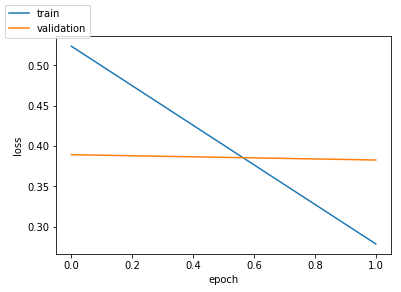

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.legend(['train', 'validation'], loc='upper left')

### Escriba aquí sus conclusiones

El error de validación se mantiene más o menos constante. Sin embargo, la accuracy (métrica que estamos optimizando) si aumenta.

# Red LSTM con GLOVE embedding 

Descargue los embeddings pre entrenados desde https://nlp.stanford.edu/projects/glove/
archivo glove.6B.zip y extraiga los datos para utilizarlos en esta sección

In [17]:
# Funciones para cargar los vectores GLOVE
def glorot_uniform_np(shape):
    fan_in, fan_out = shape[0],shape[1]
    s = np.sqrt(6. / (fan_in + fan_out))
    return np.random.uniform(-s, s, size=shape)

def load_word_vectors(embeddings_index, glove_file):
    print('Indexing word vectors.')
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    glove_file.close()
    print('Found %s word vectors.' % len(embeddings_index))    



In [18]:
# Cargando los vectores GLOVE
## LOAD PRETRAINED WORD VECTORS
GLOVE_FILE = 'glove.6B.100d.txt'
embeddings_index = {}
glove_file = open(GLOVE_FILE)
                  
load_word_vectors(embeddings_index, glove_file)   
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embeddings_index = {}

Indexing word vectors.
Found 400000 word vectors.


In [19]:
from tensorflow.keras.initializers import Constant

document_input = Input(shape=(max_words, ), dtype='int32')

embedding = Embedding(input_dim=num_words, output_dim=100, 
                      input_length=max_words, 
                      trainable=True,embeddings_initializer=Constant(embedding_matrix))
embedding_output = embedding(document_input)


In [20]:
f = Lambda(lambda x: K.sum(x,axis=1))(embedding_output)
y = Dense(20, activation='relu')(f)
output = Dense(num_classes, activation='softmax')(y)


# Construyendo el modelo
model = Model(inputs=[document_input], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='adam',
             metrics=['accuracy'])

# Entrenando el modelo
history = model.fit(X_tr_pad, y_train,
                  batch_size=batch_size,
                  epochs=2,
                  verbose=1,
                  validation_split=0.2)

Train on 12000 samples, validate on 3000 samples
Epoch 1/2
12000/12000 [==============================] - 90s 7ms/sample - loss: 1.5706 - accuracy: 0.6694 - val_loss: 0.6819 - val_accuracy: 0.7413
Epoch 2/2
12000/12000 [==============================] - 89s 7ms/sample - loss: 0.3924 - accuracy: 0.8359 - val_loss: 0.4943 - val_accuracy: 0.7887


In [21]:
loss, acc = model.evaluate(X_te_pad, y_test)
print('Accuracy en datos de test: {0}'.format(acc))

3000/3000 [==============================] - 0s 143us/sample - loss: 0.5497 - accuracy: 0.7690
Accuracy en datos de test: 0.7689999938011169


In [22]:
rnn = SimpleRNN(10,return_sequences=False)(embedding_output)


# Aplicando una capa densa luego de la RNN
output = Dense(num_classes, activation='softmax')(rnn)

# Construyendo el modelo
model = Model(inputs=[document_input], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='adam',
             metrics=['accuracy'])

# Entrenando el modelo
history = model.fit(X_tr_pad, y_train,
                  batch_size=batch_size,
                  epochs=2,
                  verbose=1,
                  validation_split=0.2)

Train on 12000 samples, validate on 3000 samples
Epoch 1/2
12000/12000 [==============================] - 89s 7ms/sample - loss: 0.6416 - accuracy: 0.6350 - val_loss: 0.8406 - val_accuracy: 0.5630
Epoch 2/2
12000/12000 [==============================] - 88s 7ms/sample - loss: 0.4640 - accuracy: 0.7947 - val_loss: 0.4980 - val_accuracy: 0.7800


In [23]:
loss, acc = model.evaluate(X_te_pad, y_test)
print('Accuracy en datos de test: {0}'.format(acc))

3000/3000 [==============================] - 1s 468us/sample - loss: 0.5250 - accuracy: 0.7687
Accuracy en datos de test: 0.768666684627533


In [24]:
rnn = SimpleRNN(10,return_sequences=False)(embedding_output)


# Aplicando una capa densa luego de la RNN
output = Dense(num_classes, activation='softmax')(rnn)

# Construyendo el modelo
model = Model(inputs=[document_input], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='adam',
             metrics=['accuracy'])

# Entrenando el modelo
history = model.fit(X_tr_pad, y_train,
                  batch_size=batch_size,
                  epochs=2,
                  verbose=1,
                  validation_split=0.2)

Train on 12000 samples, validate on 3000 samples
Epoch 1/2
12000/12000 [==============================] - 94s 8ms/sample - loss: 0.5461 - accuracy: 0.7141 - val_loss: 0.4994 - val_accuracy: 0.7717
Epoch 2/2
12000/12000 [==============================] - 93s 8ms/sample - loss: 0.3790 - accuracy: 0.8456 - val_loss: 0.8527 - val_accuracy: 0.5753


In [25]:
loss, acc = model.evaluate(X_te_pad, y_test)
print('Accuracy en datos de test: {0}'.format(acc))

3000/3000 [==============================] - 1s 473us/sample - loss: 0.8973 - accuracy: 0.5580
Accuracy en datos de test: 0.5580000281333923


In [26]:
rnn = SimpleRNN(10,dropout=0.4,return_sequences=False)(embedding_output)


# Aplicando una capa densa luego de la RNN
output = Dense(num_classes, activation='softmax')(rnn)

# Construyendo el modelo
model = Model(inputs=[document_input], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='adam',
             metrics=['accuracy'])

# Entrenando el modelo
history = model.fit(X_tr_pad, y_train,
                  batch_size=batch_size,
                  epochs=2,
                  verbose=1,
                  validation_split=0.2)

Train on 12000 samples, validate on 3000 samples
Epoch 1/2
12000/12000 [==============================] - 91s 8ms/sample - loss: 0.6789 - accuracy: 0.5838 - val_loss: 0.6301 - val_accuracy: 0.6470
Epoch 2/2
12000/12000 [==============================] - 90s 8ms/sample - loss: 0.5561 - accuracy: 0.7223 - val_loss: 0.5187 - val_accuracy: 0.7593


In [27]:
loss, acc = model.evaluate(X_te_pad, y_test)
print('Accuracy en datos de test: {0}'.format(acc))

3000/3000 [==============================] - 2s 560us/sample - loss: 0.5488 - accuracy: 0.7377
Accuracy en datos de test: 0.737666666507721


In [28]:
rnn = LSTM(10,dropout=0.4)(embedding_output)
output = Dense(num_classes, activation='softmax')(rnn)

# Construyendo el modelo
model = Model(inputs=[document_input], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='adam',
             metrics=['accuracy'])

# Entrenando el modelo
history = model.fit(X_tr_pad, y_train,
                  batch_size=batch_size,
                  epochs=3,
                  verbose=1,
                  validation_split=0.2)

Train on 12000 samples, validate on 3000 samples
Epoch 1/3
12000/12000 [==============================] - 102s 8ms/sample - loss: 0.4338 - accuracy: 0.7968 - val_loss: 0.3924 - val_accuracy: 0.8267
Epoch 2/3
12000/12000 [==============================] - 101s 8ms/sample - loss: 0.2381 - accuracy: 0.9067 - val_loss: 0.4011 - val_accuracy: 0.8340
Epoch 3/3
12000/12000 [==============================] - 96s 8ms/sample - loss: 0.1626 - accuracy: 0.9382 - val_loss: 0.4294 - val_accuracy: 0.8300


In [29]:
loss, acc = model.evaluate(X_te_pad, y_test)
print('Accuracy en datos de test: {0}'.format(acc))

3000/3000 [==============================] - 2s 517us/sample - loss: 0.4771 - accuracy: 0.8097
Accuracy en datos de test: 0.8096666932106018


# Visualizando Words Embedding con PCA (opcional, 15 ptos.)

Este ejercicio es más difícil, pero resolverlo aclarará muchas dudas sobre el funcionamiento de Keras.
Visualice los embeddings entrenados utilizando PCA.
Para esto debe seguir los siguientes pasos:
1. Obtenga los pesos de la capa de embedding, estos tendran tamaño (num_vocab, embedding_dim). Puede obtener la correspondencia entre vectores y palabras utilizando el word_index.
2. Ajuste un modelo PCA (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) y quédese con los dos componentes principales.
3. Visualice algunas palabras tomadas alreatoriamente en un gráfico de dos dimensiones y concluya.


'  -----------  '

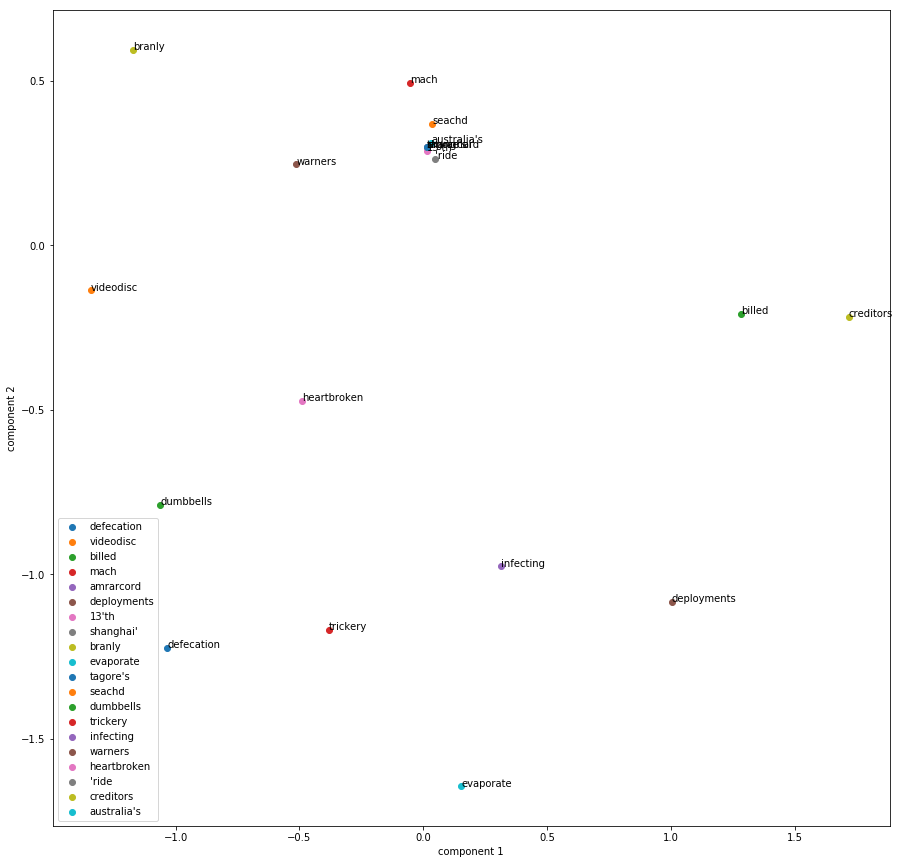

In [30]:
from sklearn.decomposition import PCA
import random
embedding_weights = embedding.get_weights()[0]
pca = PCA(n_components=2,svd_solver="full")
pca.fit(embedding_weights)
new_embeddings = pca.transform(embedding_weights)
words_embeddings = {w:new_embeddings[idx] for w, idx in word_index.items()}
fig = plt.figure(figsize=(15,15), facecolor='white')
ax = fig.add_subplot(111)
cont = 0
random.seed(0)
while(cont < 20):
    random_number = random.randint(0,len(word_index.items()))
    palabra_random = list(words_embeddings.keys())[random_number]
    ax.scatter(words_embeddings[palabra_random][0],words_embeddings[palabra_random][1], 
             marker='o',label=palabra_random)
    ax.annotate(palabra_random, (words_embeddings[palabra_random][0],words_embeddings[palabra_random][1]))
    cont += 1
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.legend()

Se puede observar como el modelo agrupa palabras positivas en la parte superior y palabras negativas en la parte inferior. Considerando que sólo se están ocupando 2 componentes, hace una buena división.